In [590]:
import json
import itertools
import pandas as pd
import numpy as np
from pymystem3 import Mystem
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/babushkinavaleriia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
with open('test_task_NLP.json') as f:
    test_task_nlp = json.load(f)

Посмотрим на данные:

In [20]:
test_task_nlp[:5]

[['Баклажаны с орехами упак',
  'Баклажаны с творожной начинкой от бренд-шефа АВ'],
 ['Блинчики с курицей упак (4 шт)', 'Блинчики с мясом, Уже Готово , 140 г'],
 ['Блинчики с мясом упак (4 шт)',
  'Блинчики с мясом, Уже Готово , 220 г, Россия'],
 ['Блины без начинки упак', 'Блины Русские от бренд-шефа АВ, Россия'],
 ['Винегрет упак',
  'Салат FreshSecret Винегрет 600г',
  'Винегрет с ароматным подсолнечным маслом, Уже Готово , 350 г']]

Объединим несколько списков в один:

In [25]:
test_list = list(itertools.chain(*test_task_nlp))
test_list[:15]

['Баклажаны с орехами упак',
 'Баклажаны с творожной начинкой от бренд-шефа АВ',
 'Блинчики с курицей упак (4 шт)',
 'Блинчики с мясом, Уже Готово , 140 г',
 'Блинчики с мясом упак (4 шт)',
 'Блинчики с мясом, Уже Готово , 220 г, Россия',
 'Блины без начинки упак',
 'Блины Русские от бренд-шефа АВ, Россия',
 'Винегрет упак',
 'Салат FreshSecret Винегрет 600г',
 'Винегрет с ароматным подсолнечным маслом, Уже Готово , 350 г',
 'Голубцы мясные тушеные в томатно-сливочном соусе от бренд-шефа АВ',
 'Голубцы мясные упак',
 'Голубцы мясные упак',
 'Запеканка творожная President Дольче ванильная 5,5% 350г']

Данные не структурированы, кроме наименования товара указываются/не указываются: 
    - граммовка товара, 
    - фирма производитель в т.ч. на английском языке, 
    - страна производитель, и т.д.
Для отделения различных признаков можно использовать регулярные выражения или находить по спискам (например, стран). В дальнейшем следует такие признаки фиксировать отдельно.
На текущий момент необходимо произвести группировку идентичных названий, само наименование товара есть практически во всех наблюдениях, попробуем поработать с тем, что есть. 
Лемматизируем текст в записях, удалим стоп-слова. Словарь стоп-слов взять стандартный из библиотеки nltk, в дальнейшем можно дополнить его словами, которые не нужны для характеристики продукта.  

In [55]:
def process_chunk(alltexts, stopwords):
    """Функция, которая лемматизирует текстовые записи"""
    mystem = Mystem()
    tagged = []
    for i in alltexts:
        processed = mystem.analyze(i)
        doc = []
        for w in processed:
            try:
                lemma = w["analysis"][0]["lex"].lower().strip()
                if lemma not in stopwords:
                    doc.append(lemma)
            except IndexError:
                pass
            except KeyError:
                pass
        tagged.append(','.join(doc))
    return tagged

def train_model(text_lemmas):
    """Функция, которая обучает новую модель на наборе данных
    (можно подавать колонку df или список списков)"""
    w2v_model = Word2Vec(
        sentences=test_series, min_count=3, window=2, size=300,
        negative=2, alpha=0.03, min_alpha=0.0007, sample=6e-5, sg=0)
    w2v_model.wv.vocab
    w2v_model.save("w2v_model.model")
    w2v_model.init_sims(replace=True)
    return w2v_model

def vectors_prepare(test_series):
    """Функция, которая собирает усредненный вектор записи"""
    vectors = []
    for i in range(test_series.shape[0]):
        a = []
        for word in test_series[i]:
            k = 0
            try:
                words = w2v_model[word]
                if k == 0:
                    words = words*10
                a.append(words)
                k += 1
            except KeyError:
                continue
            a_m = np.mean(np.asarray(a), axis=0)
        vectors.append(a_m)
    return vectors

In [546]:
stopwords = stopwords.words('russian')
test_lemmas = process_chunk(test_list, stopwords)
test_lemmas[:10]

['баклажан,орех,упак',
 'баклажан,творожный,начинка,бренд,шеф,ава',
 'блинчик,курица,упак',
 'блинчик,мясо,готовый,г',
 'блинчик,мясо,упак',
 'блинчик,мясо,готовый,г,россия',
 'блин,начинка,упак',
 'блин,русский,бренд,шеф,ава,россия',
 'винегрет,упак',
 'салат,винегрет']

Попробуем подход с векторизацией записей, подготовим записи для обучения модели и обучим ее: 

In [547]:
test_series = pd.Series(test_lemmas, copy=False)
test_series = test_series.apply(lambda x: x.split(','))
test_series[:10]

0                             [баклажан, орех, упак]
1    [баклажан, творожный, начинка, бренд, шеф, ава]
2                            [блинчик, курица, упак]
3                        [блинчик, мясо, готовый, г]
4                              [блинчик, мясо, упак]
5                [блинчик, мясо, готовый, г, россия]
6                              [блин, начинка, упак]
7           [блин, русский, бренд, шеф, ава, россия]
8                                   [винегрет, упак]
9                                  [салат, винегрет]
dtype: object

In [438]:
w2v_model = train_model(test_series)

Соберем вектора для всех записей в нашем семпле:

In [548]:
vectors = vectors_prepare(test_series)
print(len(vectors))
print(vectors[0])

/var/folders/_z/bhy5vwy90pzd9s4jngc90jzr0000gn/T/ipykernel_17325/2644001596.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  words = w2v_model[word]


3580
[-0.74499315  0.15046702 -0.14615141 -0.10263971 -0.15170725  0.18581225
  0.47503135  0.654316    0.36707208 -0.17016466  0.7446231   0.356678
  0.5112896   0.13357551  0.26814115 -0.2564294  -0.13026606  0.36192146
 -0.21789129 -0.32314447 -0.46575272  0.2111315  -0.5673366   0.41539788
  0.17884143  0.33106676 -0.03463736  0.06345842  0.21435411  0.37155893
  0.4480009   0.3809147   0.00966125 -0.2917034  -0.1224905   0.13146101
 -0.12357282  0.12979418 -0.18841623  0.8699309  -0.28218535  0.22862582
  0.7972064  -0.6000631   0.03926015  0.4524695  -0.08382469  0.05143424
  0.33220258 -0.04115749 -0.09667423  0.1153767  -0.05076553  0.5077662
 -0.53837293  0.10861465  0.22552235 -0.0310916   0.4534649   0.4699024
 -0.22342026  0.38045868 -0.38282514 -0.17141016 -0.04383326  0.2013154
  0.4570582  -0.27799305  0.01535881 -0.1392944  -0.02563836  0.7331212
  0.36090788 -0.26916793 -0.4601004  -0.22642928  0.5574162   0.14436175
 -0.08332416  0.02629192 -0.22135426 -0.21345675  0.

Уменьшим размерность векторов для визуализации и попробуем подорать оптимальное количество для кластеризации.

In [605]:
pca = PCA(n_components=2)
PCA_result = pca.fit_transform(vectors)
PCA_df = pd.DataFrame(PCA_result)

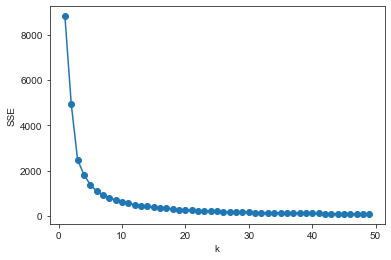

In [601]:
SSE = [] 
for k in range(1,50):
    estimator = KMeans(n_clusters = k)
    estimator.fit(PCA_df)
    SSE.append(estimator.inertia_)
    
X = range(1,50)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X,SSE,'o-')
plt.show()

Оптимальное количество кластеров 8-10, кластеризуем записи: 

In [606]:
kmeans = KMeans(n_clusters= 9)
label_pca = kmeans.fit_predict(PCA_result)

In [607]:
sample_series = pd.Series(test_list, copy=False)
PCA_result = pd.DataFrame(PCA_result)
PCA_result['x_values'] =PCA_result.iloc[0:, 0]
PCA_result['y_values'] =PCA_result.iloc[0:, 1]
PCA_result['lemmas'] = test_series
PCA_result['product'] = sample_series
PCA_result['cluster'] = list(label_pca)
PCA_result = PCA_result[['product', 'lemmas', 'cluster', 'x_values', 'y_values']]
PCA_result.head(30)

,product,lemmas,cluster,x_values,y_values
0,Баклажаны с орехами упак,"[баклажан, орех, упак]",0,-0.916091,0.476804
1,Баклажаны с творожной начинкой от бренд-шефа АВ,"[баклажан, творожный, начинка, бренд, шеф, ава]",8,-0.353554,0.225467
2,Блинчики с курицей упак (4 шт),"[блинчик, курица, упак]",8,-0.246853,0.410647
3,"Блинчики с мясом, Уже Готово , 140 г","[блинчик, мясо, готовый, г]",8,0.130051,0.579191
4,Блинчики с мясом упак (4 шт),"[блинчик, мясо, упак]",8,-0.061841,0.905792
5,"Блинчики с мясом, Уже Готово , 220 г, Россия","[блинчик, мясо, готовый, г, россия]",1,1.772588,-0.264474
6,Блины без начинки упак,"[блин, начинка, упак]",8,-0.228745,0.713294
7,"Блины Русские от бренд-шефа АВ, Россия","[блин, русский, бренд, шеф, ава, россия]",3,1.141628,-0.259705
8,Винегрет упак,"[винегрет, упак]",8,-0.590796,0.861296
9,Салат FreshSecret Винегрет 600г,"[салат, винегрет]",0,-0.836975,0.379128


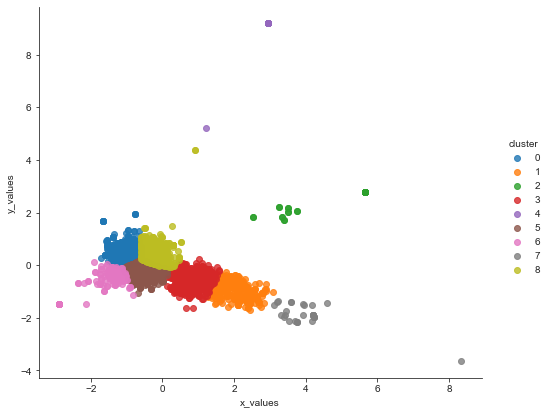

In [610]:
sns.set_style('ticks')
fig = sns.lmplot(x='x_values', y='y_values',
           data = PCA_result,
           fit_reg=False,
           legend=True,
           hue='cluster')
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.show()

In [611]:
PCA_result.to_csv('PCA_result.csv')

In [612]:
PCA_result[PCA_result['product'] == 'Кисломолочный напиток Актимель ежевично-черничный 100 г']

,product,lemmas,cluster,x_values,y_values
2310,Кисломолочный напиток Актимель ежевично-чернич...,"[кисломолочный, напиток, актимель, ежевичный, ...",5,-1.010585,-0.075989


In [613]:
PCA_result[PCA_result['product'] == 'Напиток Данон Актимель черника/ежевика 2,5% 6*0,1л Россия']

,product,lemmas,cluster,x_values,y_values
2311,"Напиток Данон Актимель черника/ежевика 2,5% 6*...","[напиток, данон, актимель, черника, ежевика, р...",3,0.472584,-1.209804


In [614]:
PCA_result[PCA_result['product'] ==  "Гель для душа Роскошная мягкость Черная орхидея Palmolive, 250 мл"]

,product,lemmas,cluster,x_values,y_values
120,Гель для душа Роскошная мягкость Черная орхиде...,"[гель, душа, роскошный, мягкость, черный, орхи...",0,-0.765834,0.241768


In [615]:
PCA_result[PCA_result['product'] ==  'Гель для душа Palmolive "Черная орхидея" 250 мл']

,product,lemmas,cluster,x_values,y_values
123,"Гель для душа Palmolive ""Черная орхидея"" 250 мл","[гель, душа, черный, орхидея, мл]",0,-0.980105,0.338143


In [616]:
PCA_result[PCA_result['product'] ==  'Корм Whiskas говядина/кролик канапе новогодний 85г Россия']

,product,lemmas,cluster,x_values,y_values
288,Корм Whiskas говядина/кролик канапе новогодний...,"[корм, говядина, кролик, канапе, новогодний, р...",3,1.26114,-0.841425


Итого: 
    - исходные данные нуждаются в дополнительной очистки от ненужных атрибутов для описание наименования продукта, 
    - дополнить словарь стоп-слов не характерными словами для описания наименования продукта.